<a href="https://colab.research.google.com/github/ZabalaGaston/HPC/blob/main/Zabala_Gaston_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Introducción

La ley de la gravitación universal formulada por Isaac Newton postula que la fuerza que ejerce una partícula puntual con masa **m1** sobre otra con masa **m2** es directamente proporcional al producto de las masas, e inversamente proporcional al cuadrado de la distancia que las separa: [1]

>$F = G\frac{m1* m2}{r^2} $

**G** es la constante de gravitación universal y vale aproximadamente 6,674 * 10^-11

La masa de la Tierra es 5,974 × 1024 kg. 

A modo de demostración del ejercicio, se incluyo al inicio el calculo en el lenugaje Python[1,2,3] con el fin de representar en forma gráfica el resultado obtenido. 

En este ejercico, se busca realizar una comparación directa entre una ejecución en serie y una en paralelo sobre el mismo juego de valores. Para ello, se utilizara **OpenMP[5]** para realizar en varios hilos de ejecución una programación paralela.



#2 Armado del ambiente

No son necesarios, ejecuciones previas del armado del ambiente.

#3 Desarrollo
Ejemplo desarrollado en Python. En esta sección, ejecutaremos el algoritmo para x cantidad de elementos ingresados por parámetro. <br>
Luego, realizaremos un muestreo de los datos obtenidos en dos gráficos. Si bien muestran la misma información, pudimos explorar como realizar gráficos y como mostrarlos en simultáneo, haciendo uso de subplot [6].

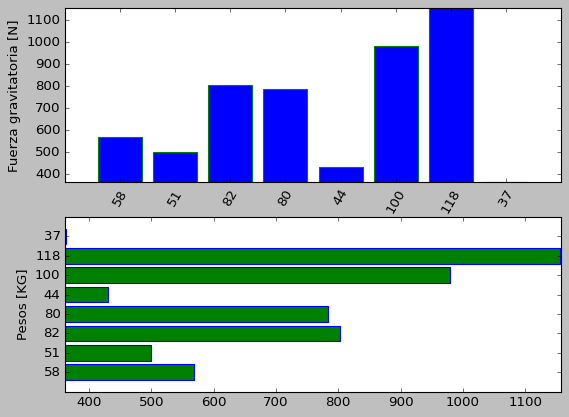

In [148]:
#@title ## Parámetros de ejecución

#@markdown ---
#@markdown ### Especifique la cantidad de elementos a las cuales se les va a calcular la fuerza gravitatoria:

elementos = 628338#@param {type:"slider", min:10, max:2000000, step:1}

try:
  import numpy as np
  import matplotlib.pyplot as plt

  # Variables constantes
  r = 6378140
  G = 6.674 * pow(10,-11);
  masaTierra = 5.974 * pow(10,24);
  pesoMinimo = 30
  pesoMaximo = 120
  
  # Creo el vector con las masas de los cuerpos
  v_masasCuerpos  = np.random.randint(pesoMinimo, pesoMaximo, size=elementos)
  v_fg  = np.zeros(elementos)

  for i in range( 0, elementos ):
    v_fg[i] = G * masaTierra  *  v_masasCuerpos[i] / pow(r,2);

  x = 8 # Estoy limitando a que me muestre x resultados
  #v_fg[0:x] recupera valores de 0 a x, esto lo hago para que no 
  #quede un grafico extenso

  plt.title("Muestra de resultados obtenidos" )

  plt.subplot(2, 1, 1)
  plt.ylabel('Fuerza gravitatoria [N]')
  plt.bar(range(x), v_fg[0:x], edgecolor = "green", color = "blue")
  plt.xticks (range(x), v_masasCuerpos[0:x],rotation = 60)
  plt.ylim(min(v_fg[0:x])-1,max(v_fg[0:x])+1)

# creamos el segundo panel
  plt.subplot(2, 1, 2)
  plt.barh(range(x), v_fg[0:x], edgecolor = "blue", color = "green")
  plt.yticks (range(x), v_masasCuerpos[0:x])
  plt.xlim(min(v_fg[0:x])-1,max(v_fg[0:x])+1)
  plt.ylabel('Pesos [KG]')

except ModuleNotFoundError:
  print("Error en modulos utilizados")
except Exception as e:
  print("Error:",e.args)

##3.1 Generar code_fg.cpp
Mediante código Python, genero una cadena de texto con código C. Luego, guardo la cadena en el archivo code_fg.cpp

In [139]:
code = """

#include <iostream>
#include <vector>
#include <cstdlib>
#include <sys/time.h>
#include <math.h>
#include <omp.h> //Cabecera OpenMP

//------------------------------------------------
// Macros para medir el tiempo

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000; // Devuelvo en milisegundos
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_TOTAL     1
#define HTH_FG_SEC  2
#define HTH_FG_OMP  3
#define DISTANCIA  6378140
//---------------------------------------------------------

int main(int argc, char*argv[])
{
  int i,c;
  TIEMPO_INI ( HTH_TOTAL )

  //Leo los parametros.
  if (argc != 3 )
  {
    std::cerr<<"Error al ingresar los parámetros" <<std::endl;
    exit( - 1 );
   }

   int cantidadCuerpos  =  atoi( argv[1] );
   int ciclos           =  atoi( argv[2] );

   double masaTierra;
   double g;

   g = 6.674 * pow(10,-11);
   masaTierra = 5.974 * pow(10,24);
    
   if ( cantidadCuerpos <= 0)
   {
      std::cerr<<"La cantidad de cuerpos debe ser mayor a 0 [Parametro 1]" <<std::endl;
      exit( - 2 );
   }

   if ( ciclos <= 0)
   {
      std::cerr<<"La cantidad de ciclos debe ser mayor a 0 [Parametro 2]" <<std::endl;
      exit( - 3 );
   }

   //-----------------------------------------------------
   // Defino la memoria de los vectores para la masa de los cuerpos

   std:: vector<double>   masaCuerpos ( cantidadCuerpos );
   std:: vector<double>   fuerzaGrav ( cantidadCuerpos );

   for (int i = 0; i < cantidadCuerpos; i++)
   {
      masaCuerpos[i] = (rand()/(double)RAND_MAX)*100.0; 
   }

  //------------------------------------------
  // Realizo el cálculo de la fuerza gravitatoria de los cuerpos con relación a la tierra en forma secuencial

  TIEMPO_INI ( HTH_FG_SEC )

  for(c=0; c<ciclos; c++)
  {
    for(i=0; i< cantidadCuerpos ; i++)
    {
       fuerzaGrav[i] = g * masaTierra  *  masaCuerpos[i] / pow(DISTANCIA,2);
    }
  }

  TIEMPO_FIN ( HTH_FG_SEC )

  // ---------------------------------------------
  // Realizo el cálculo de la aceleración con OpenMP

  TIEMPO_INI ( HTH_FG_OMP )

  for(c=0; c<ciclos; c++)
  {
    #pragma omp parallel for
    for(i=0; i< cantidadCuerpos ; i++)
    {
      fuerzaGrav[i] = g * masaTierra  *  masaCuerpos[i] / pow(DISTANCIA,2);
    }
  }

  TIEMPO_FIN ( HTH_FG_OMP )

  //------------------------------------------------
  std::cout<<"Valores Reales  : " <<std::endl;
  std::cout<<"Tiempo Fuerza gravitatoria sec : " <<TIEMPO_GET(HTH_FG_SEC)<< " [ms]"<<std::endl;
  std::cout<<"Tiempo Fuerza gravitatoria Omp : " <<TIEMPO_GET(HTH_FG_OMP)<< " [ms]"<<std::endl;
  std::cout<<std::endl;  
  std::cout<<"SpeedUp          :  (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_FG_SEC)<<" / "<<TIEMPO_GET(HTH_FG_OMP)<<" = "<<TIEMPO_GET(HTH_FG_SEC)/TIEMPO_GET(HTH_FG_OMP)<<std::endl;
  std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_FG_SEC)/TIEMPO_GET(HTH_FG_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_FG_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_FG_OMP))<<std::endl;

  std::cout<<"-------------------------------------------------------------------------------------"<<std::endl;
  std::cout<<std::endl;
  std::cout<<"Valores Ideal: "<<std::endl;
  TIEMPO_GET(HTH_FG_OMP) = TIEMPO_GET(HTH_FG_SEC) / 2;
  std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_FG_SEC)<<" / "<<TIEMPO_GET(HTH_FG_OMP)<<" = "<<TIEMPO_GET(HTH_FG_SEC)/TIEMPO_GET(HTH_FG_OMP)<<std::endl;
  std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_FG_SEC)/TIEMPO_GET(HTH_FG_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_FG_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_FG_OMP))<<std::endl;
  std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_FG_SEC)<<" = "<<TIEMPO_GET(HTH_FG_SEC)<<std::endl;
  std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_FG_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_FG_OMP)<<std::endl;
  std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_FG_OMP)<<" - "<<TIEMPO_GET(HTH_FG_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_FG_OMP))-TIEMPO_GET(HTH_FG_SEC)<<std::endl;

}
"""

text_file = open("code_fg.cpp","w")
text_file.write(code)
text_file.close()



##3.2 Compilación de código C (cálculo de aceleración)

In [140]:
!g++ -o fg -fopenmp code_fg.cpp

##3.3 Configuro cantidad de hilos a ejecutar en forma paralela

In [141]:
%env OMP_NUM_THREADS=2

env: OMP_NUM_THREADS=2


Ejecución del calculo de la fuerza gravitatoria en Serie y Paralela

In [145]:
# --------------------------------------------
from datetime import datetime
tiempo_total = datetime.now()

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

#----------------------------------------------------------------------
try:

#---- Ejecución

# Parámetros:
# 2 -> Cantidad de Cuerpos
# 3 -> Cantidad de ciclos

  !./fg 10000000 50
#----

  tiempo_total = datetime.now() - tiempo_total;
  print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )

except Exception as e:
  print("Error:",e.args)

Valores Reales  : 
Tiempo Fuerza gravitatoria sec : 8408.22 [ms]
Tiempo Fuerza gravitatoria Omp : 7711.97 [ms]

SpeedUp          :  (tiempo Secuencial/tiempo paralelo) : 8408.22 / 7711.97 = 1.09028
Eficiencia       : SpeedUp/nro procesadores            : 1.09028 / 2 = 0.545141
-------------------------------------------------------------------------------------

Valores Ideal: 
SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 8408.22 / 4204.11 = 2
Eficiencia       : SpeedUp/nro procesadores            : 2 / 2 = 1
Coste Sec        : nro procesadores*Tiempo             : 1 * 8408.22 = 8408.22
Coste Omp        : nro procesadores*Tiempo             : 2 * 4204.11 = 8408.22
Funcion Overhead : Coste Omp - tiempo Secuencial       : 8408.22 - 8408.22 = 0
Tiempo Total:  16493.506 [ms]


#4 Tabla de pasos
Solo aplica a la comparacion entre Serie - Paralelo con OpenMP


 Procesador | Función | Detalle
------------|---------|----------
CPU      |  #includes | Librerias necsarias para el desarrollo del ejercicion en C++.
CPU      |  #define     | Definicion de macros utilizadas en el proceso..
CPU      |main()       | 	Funcion principal.
CPU      |  TIEMPO_INI  | Toma el tiempo inicial para la ejecucion en serie..
CPU      |  argc != 3        | Validacion de parametro.
CPU      |  std::vector|Definición de vector 
CPU      |  for(...)        | Cálculo de la fuerza de gravitatoria
CPU      |  TIEMPO_FIN               | Captura el tiempo final para la ejecución en serie.
CPU      | TIEMPO_INI                | Toma el tiempo inicial para la ejecución en paralelo.
CPU      | #pragma | Defino el sector que se va a ejecutar en paralelo, indicando que variables van a ser compartidas por los distintos hilos de ejecucion
CPU | for(...) | Ejecución de cálculo de fuerza gravitatoria.
CPU | TIEMPO_FIN | Toma el tiempo final para la ejecución en paralelo
CPU | std:: | Muestro las estadísticas
CPU | open(...) | Apertura del archivo C++.
CPU | write(...) | Escritura del archivo C++.
CPU | close (...) | Cierre del archivo C++.
CPU | !g++ | Compilación del código.
CPU | %env | Definición de cantidad hijos a ejecutar en paralelo.
CPU | !./fg 10000000 50 | Ejecución del código, pasando por parámetro la cantidad de cuerpos y la cantidad de ciclos 


#5 Conclusión

Mediante la realización de ejercicio, pude comprender el funcionamiento con hilos en ejecución a traves de OpenMP.

Podemos observar que los tiempos para calcular la fuerza gravitatoria de manera  secuencial son mayores que al calcular la misma en paralelo (OpenMP).

*Tiempo Acel sec : 828.774 [ms] <br>
Tiempo Acel Omp : 763.55 [ms] <br>
Tiempo Total:     1729.769 [ms]*


En los casos cuando la cantidad de elementos para calcularle al fuerza gravitatoria es pequeño, la ejecución en serie obtiene mejores resultados debido a que se agrega un tiempo extra en comenzar a ejecutar las operaciones en paralelo. En cambio, cuando la cantidad de elementos es elevada, en paralelo se ejecuta mas rapido, gracias a que cada hilo resuelve parte del problema y todo se ejecuta en fomra simultanea.

El punto más relevante en este ejercicio es demostrar el funcionamiento y utilizacion de OpenMP para la ejecución en paralelo. La sentencia #pragma omp parallel for, nos indica que la parte de código que la comprende puede ser ejecutada por varios hilos. Se crea una tarea implícita para cada hilo perteneciente al equipo de hilos creado por el parallel.(Por defecto, openmp sabe que vamos a iterar por el valor i).  

En cuanto a lecciones aprendidas, comprendí el funcionamiento de OpenMP, como así también realizar gráficos a partir de los datos obtenidos. <br>


#6 Bibliografía

[1] Fuerza gravitatoria: [Referencia](https://www.fisicalab.com/apartado/fuerza-gravitatoria#:~:text=Esta%20ley%20establece%20que%20los,por%20qu%C3%A9%20orbitan%20los%20planetas.)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Numpy: [Referencia](https://numpy.org/doc/1.16/reference/routines.random.html)

[4] Sliders Parametros: [Referencia](https://colab.research.google.com/notebooks/forms.ipynb)

[5] openMP: [Enlace](https://es.wikipedia.org/wiki/OpenMP)

[6] Subplots: [Enlace](https://www.interactivechaos.com/manual/tutorial-de-matplotlib/la-funcion-subplots)

[7] Gráficos: [Enlace](https://colab.research.google.com/github/ElDwarf/DS_and_ML_Docs/blob/master/notebooks/01_Data_analysis/03_instroduction_matplotlib.ipynb#scrollTo=lzpQvfhd5jPd)